# Introduction

How numpy is used determines in large part the performance of the code.  In this notebook a number of such issues will be addressed.

# Requirements

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import timeit

# Fancy indexing

Fancy indexing of numpy arrrays has a significant influence on performance.

In [5]:
A = np.random.uniform(-1.0, 1.0, size=(1_000, 1_000))
B = np.random.uniform(0.0, 1.0, size=A.shape)

In [6]:
def flip_sign(A, B):
    for i in range(A.shape[0]):
        for j in range(A.shape[1]):
            if B[i, j] > 0.5:
                A[i, j] = -A[i, j]

In [7]:
%timeit flip_sign(A, B)

152 ms ± 1.92 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [8]:
%timeit A[B > 0.5] = -A[B > 0.5]

9 ms ± 49.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


How does the matrix size influence the performance difference?

In [9]:
def fancy_indexing_timings(n_values):
    fancy_times = np.empty(len(n_values))
    function_times = np.empty(len(n_values))
    for i, n in enumerate(n_values):
        setup = f'''import numpy as np
A = np.random.uniform(-1.0, 1.0, size=({n}, {n}))
B = np.random.uniform(0.0, 1.0, size=A.shape)
def flip_sign(A, B):
    for i in range(A.shape[0]):
        for j in range(A.shape[1]):
            if B[i, j] > 0.5:
                A[i, j] = -A[i, j]'''
        timer = timeit.Timer('A[B > 0.5] = -A[B > 0.5]', setup=setup)
        timing = timer.autorange()
        fancy_times[i] = timing[1]/timing[0]
        timer = timeit.Timer('flip_sign(A, B)', setup=setup)
        timing = timer.autorange()
        function_times[i] = timing[1]/timing[0]
    return function_times/fancy_times

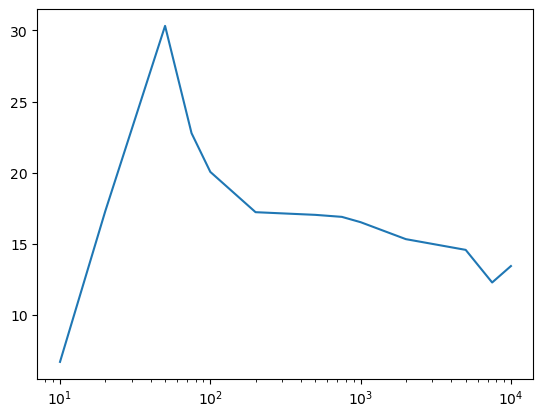

In [10]:
n_values = [10, 20, 50, 75, 100, 200, 500, 750, 1_000, 2_000, 5_000, 7_500, 10_000]
times = fancy_indexing_timings(n_values)

plt.plot(n_values, times)
plt.xscale('log');

Note that this may be an artifact of cache reuse.

In [25]:
def fancy_indexing_no_cache_imings(n_values, number=10, repeats=5):
    fancy_times = np.empty(len(n_values))
    function_times = np.empty(len(n_values))
    for i, n in enumerate(n_values):
        setup = f'''import numpy as np
As = [np.random.uniform(-1.0, 1.0, size=({n}, {n})) for _ in range({number})]
Bs = [np.random.uniform(0.0, 1.0, size=As[0].shape) for _ in range({number})]
def flip_sign(A, B):
    for i in range(A.shape[0]):
        for j in range(A.shape[1]):
            if B[i, j] > 0.5:
                A[i, j] = -A[i, j]'''
        timer = timeit.Timer('for A, B in zip(As, Bs): A[B > 0.5] = -A[B > 0.5]', setup=setup)
        timing = timer.repeat(repeats, 1)
        fancy_times[i] = np.average(timing)
        timer = timeit.Timer('for A, B in zip(As, Bs): flip_sign(A, B)', setup=setup)
        timing = timer.repeat(repeats, 1)
        function_times[i] = np.average(timing)
    return function_times/fancy_times

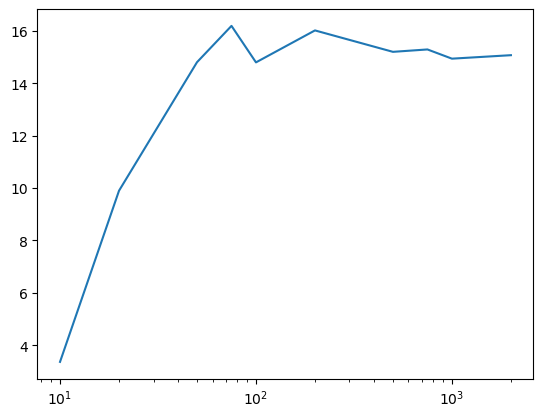

In [24]:
n_values = [10, 20, 50, 75, 100, 200, 500, 750, 1_000, 2_000]
times = fancy_indexing_no_cache_imings(n_values)

plt.plot(n_values, times)
plt.xscale('log');

Indeed, the peak was due to cache effects.

# Array functions

We can similarly quantify the difference in performance between applying the square root function while iterating over an array to applying the function to the array as a whole.

In [59]:
def sqrt_timings(n_values):
    fancy_times = np.empty(len(n_values))
    function_times = np.empty(len(n_values))
    for i, n in enumerate(n_values):
        setup = f'''import numpy as np
A = np.random.uniform(0.0, 1.0, size=({n}, {n}))
B = np.empty_like(A)
def my_sqrt(A, B):
    for i in range(A.shape[0]):
        for j in range(A.shape[1]):
            B[i, j] = np.sqrt(A[i, j])'''
        timer = timeit.Timer('B = np.sqrt(A)', setup=setup)
        timing = timer.autorange()
        fancy_times[i] = timing[1]/timing[0]
        timer = timeit.Timer('my_sqrt(A, B)', setup=setup)
        timing = timer.autorange()
        function_times[i] = timing[1]/timing[0]
    return function_times/fancy_times

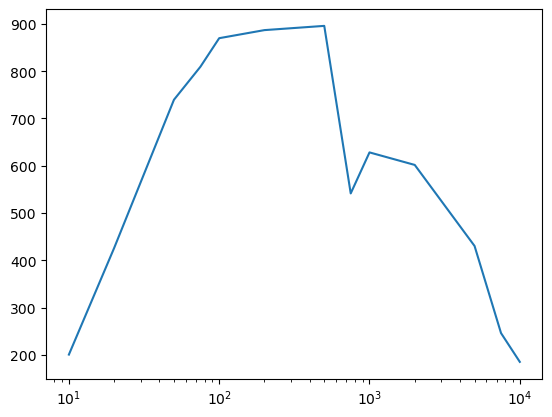

In [60]:
n_values = [10, 20, 50, 75, 100, 200, 500, 750, 1_000, 2_000, 5_000, 7_500, 10_000]
times = sqrt_timings(n_values)

plt.plot(n_values, times)
plt.xscale('log');

The difference is huge, checking for cache effects to make sure we are not looking at artifacts.

In [34]:
def sqrt_no_cache_timings(n_values, number=10, repeats=5):
    fancy_times = np.empty(len(n_values))
    function_times = np.empty(len(n_values))
    for i, n in enumerate(n_values):
        setup = f'''import numpy as np
As = [np.random.uniform(0.0, 1.0, size=({n}, {n})) for _ in range({number})]
Bs = [np.empty_like(As[0]) for _ in range({number})]
def my_sqrt(A, B):
    for i in range(A.shape[0]):
        for j in range(A.shape[1]):
            B[i, j] = np.sqrt(A[i, j])'''
        timer = timeit.Timer('for A, B in zip(As, Bs): B = np.sqrt(A)', setup=setup)
        timing = timer.repeat(repeats, number=1)
        fancy_times[i] = np.average(timing)
        timer = timeit.Timer('for A, B in zip(As, Bs): my_sqrt(A, B)', setup=setup)
        timing = timer.repeat(repeats, number=1)
        function_times[i] = np.average(timing)
    return function_times/fancy_times

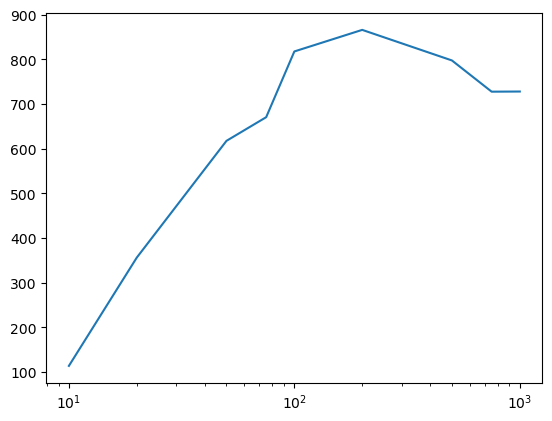

In [36]:
n_values = [10, 20, 50, 75, 100, 200, 500, 750, 1_000,]
times = sqrt_no_cache_timings(n_values)

plt.plot(n_values, times)
plt.xscale('log');